# CAB420, Practical 4, Question 1 Solution
## Implementing an AlexNet-Like Network

Deep Neural Networks have exploded in popularity in recent years due to their impressive performance. For the most part, neural networks are very adaptable and a network that performs well on one task will perform similarly well on another similar task (here, we can consider both tasks being image classification to make them sufficiently similar), assuming that other factors such as dataset characteristics are similar. Given this, it is very common to see the same, or very similar architecture used over and over again. These architectures are typically based on large models that have performed well (or won) a popular image classification benchmark, the ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

The first deep network to win the ILSVRC challenge was [AlexNet](https://proceedings.neurips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). The structure of AlexNet is shown in the prac sheet, and consists of:
* An input, of size $224 \times 224 \times 3$ (i.e. a 224 pixel wide, by 224 pixel high, colour image).
* A 2D Convolution layer with $96$ $11 \times 11$ sized filters, followed by max pooling layer that operates over a $4\times 4$ region.
* A 2D Convolution layer with $256$ $5 \times 5$ sized filters, followed by a max pooling layer.
* A 2D Convolution layer, with $384$ $3 \times 3$ size filters.
* A 2D Convolution layer, with $384$ $3 \times 3$ size filters.
* A 2D Convolution layer, with $256$ $3 \times 3$ size filters.
* A fully connected (or dense) layer with $4096$ units.
* A fully connected (or dense) layer with $4096$ units.
* An output fully connected (or dense) layer, with $1000$ units (for the $1000$ classes in ImageNet).

Using this network on the CIFAR-10 dataset is not practical, but we can adapt the AlexNet architecture to CIFAR-10. You are to create a network of a similar style AlexNet, but tailored for CIFAR-10. A suggested approach would be:
* Use three 2D convolution layers (with max pooling in between), with filters of decreasing size, but increasing in number in similar ratios to AlexNet (i.e. the first convolution layer has 8 $7\times 7$ filters, the second has 24 $5\times 5$ filters, the third has 32 $3 \times 3$ filters). Use $4\times 4$ max pooling after the first layer, and $2\times 2$ after the second.
* Use two dense (fully connected) layers, one with $512$ units after the convolution layers, and then a final classification layer with $10$ units (i.e. the number of output classes).
* Use relu activations throughout, except for your output layer which should use a soft-max layer.

Train the network on the CIFAR-10 dataset, and evaluate the performance. When training the model, be sure to consider the dataset size ($50,000$ training samples) and batch size when selecting how many epochs to train for. Assuming you're using an optimiser such as Adam with default values, $\approx5000$ iterations will likely be sufficient to train your network to near convergence. After training, plot the training and validation losses and accuracies to observe if the model has converged, or is overfitting.

### Relevant Examples

The DCNN examples from this week, in particular ``CAB420_DCNNs_Example_1_Classification_with_Deep_Learning.ipynb`` is a good starting point and has examples of how to build and train a neural network.

### Suggested Packages

TensorFlow and Keras are your friends here. Matplotlib and maybe seaborn will be good for plotting, and sklearn also provides some useful functionality for confusion matricies and accuracy metrics.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical

# metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy

## Loading the Data

CIFAR-10 is built into keras, so we can load that directly. Note that we will:
* Convert the y-data to categoricals
* Plot some example images as a sanity check

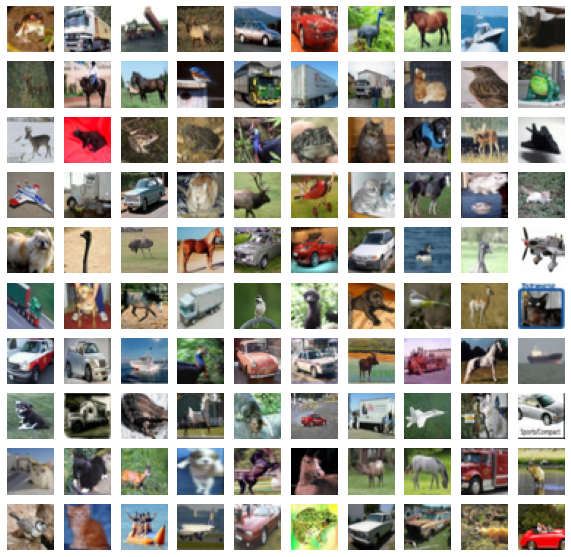

In [2]:
# load the data through the keras API
(train, train_y), (test, test_y) = keras.datasets.cifar10.load_data()

# convert the y-data to categoricals
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

# plot some images
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,:])
    ax.axis('off')

## Building The Network

We'll follow the suggested layout in the prac sheet, but you could increase or decrease the size of the network to suit your own hardware. If you do, aim to keep the relative size of layers the same (i.e. if you increase the number of conv filters in the first layer to 16, double the number of filters in the other layers too).

In [3]:
# network input, images are 32 pixels square, and colour; so our size is 32 x 32 x 3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')

# 7x7 conv block, we have a conv2D layer with 8 filters
x = layers.Conv2D(filters=8, kernel_size=(7, 7), padding='same', activation=None)(inputs)
# I've split the activation out from the conv layer here for clarity, though I don't need to do this
x = layers.Activation('relu')(x)
# max pooling, with a 4x4 window. This will reduce the representation size from 32x32 to 8x8
x = layers.MaxPool2D(pool_size=(4, 4))(x)

# 5x5 conv block, the structure here is the same as the first block, but I've got a smaller kernel and more
# filters. In AlexNet, the filters increase from 96 -> 256; so here I've gone with a similar increase from
# 8 -> 24
x = layers.Conv2D(filters=24, kernel_size=(5, 5), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, again there is an increase in the number of filters (Alexnet went from 256 -> 384, 
# so I've done similar). Note that there is no max-pooling here, as per the later conv layers of ALexNet
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)

# flatten layer
x = layers.Flatten()(x)

# dense layer, 512 neurons
x = layers.Dense(512, activation='relu')(x)

# the output, 10 neurons for 10 classes
outputs = layers.Dense(10, activation='softmax')(x) #no digits cause of softmax

# build the model, and print a summary
model_alexnet = keras.Model(inputs=inputs, outputs=outputs, name='alexnet_for_cifar10')
model_alexnet.summary()

Model: "alexnet_for_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         1184      
                                                                 
 activation (Activation)     (None, 32, 32, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 24)          4824      
                                                                 
 activation_1 (Activation)   (None, 8, 8, 24)          0         
                                               

We have ~280,000 parameters, the vast majority of them in the first dense layer.

## Train the Network

To train the network, we'll
* Use categorical cross entropy, as we have a run-of-the-mill amulti-class classification task
* Use Adam with the default parameters
* Train for 12 epochs. We have $50,000$ training samples, and a batch size of $128$, so in one epoch we'll see $\frac{50000}{128} = 391$ batches of data, i.e. $391$ updates to the model. As we would like to get to $\approx 5000$ training iterations, we'll train for 12 epochs.

In [4]:
model_alexnet.compile(
    # categorical cross entropy loss
    loss='categorical_crossentropy',
    # adam optimiser
    optimizer=keras.optimizers.Adam(),
    # compute the accuracy metric, in addition to the loss 
    metrics=['accuracy'])

# train the model
# we'll capture the returned history object that will tell us about the training performance
history = model_alexnet.fit(train, train_y,
                    batch_size=128,
                    epochs=12,
                    validation_data=(test, test_y), verbose=True)

Epoch 1/12
391/391 [==============================] - 21s 37ms/step - loss: 2.3233 - accuracy: 0.2931 - val_loss: 1.6898 - val_accuracy: 0.3981
Epoch 2/12
391/391 [==============================] - 11s 28ms/step - loss: 1.5928 - accuracy: 0.4276 - val_loss: 1.5254 - val_accuracy: 0.4506
Epoch 3/12
391/391 [==============================] - 12s 30ms/step - loss: 1.4381 - accuracy: 0.4847 - val_loss: 1.4908 - val_accuracy: 0.4703
Epoch 4/12
391/391 [==============================] - 11s 29ms/step - loss: 1.3153 - accuracy: 0.5340 - val_loss: 1.4300 - val_accuracy: 0.4989
Epoch 5/12
391/391 [==============================] - 11s 28ms/step - loss: 1.2166 - accuracy: 0.5639 - val_loss: 1.4687 - val_accuracy: 0.4852
Epoch 6/12
391/391 [==============================] - 11s 28ms/step - loss: 1.1304 - accuracy: 0.5979 - val_loss: 1.4270 - val_accuracy: 0.5110
Epoch 7/12
391/391 [==============================] - 11s 29ms/step - loss: 1.0429 - accuracy: 0.6312 - val_loss: 1.4964 - val_accuracy:

## Evaluation

Evaluate the model, we'll look at
* Training convergence, by exploring the loss and accuracy on the training and validation datea
* Confusion matricies and F1 scores on the training and validation data

### Training Convergence

We'll plot
* Training and validation loss. We'd like to see the loss converge, i.e. the plots flatten out to a constant. We expect there to be a difference between training and validation loss (training loss being slower), but we'd like these two lines to be as close as possible.
* Training and validation accuracy. As with the loss, we'd like to see these converge. We expect the validation accuracy to be below the training accuracy, but again we'd like them to be close.

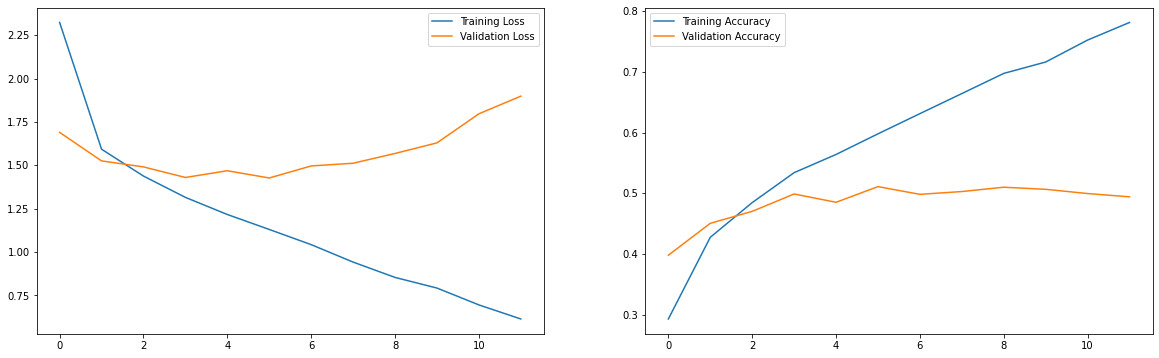

In [5]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend()

What we observe above is overfitting. Training loss and accuracy continue to improve, yet on the validation set we see the validation loss go backwards, and validation accuracy flatline.

From these plots, we could have stopped training after approximatley 6 epochs.

### Accuracy

We'll plot confusion matrices for the training and testing set, and compute F1 scopes.

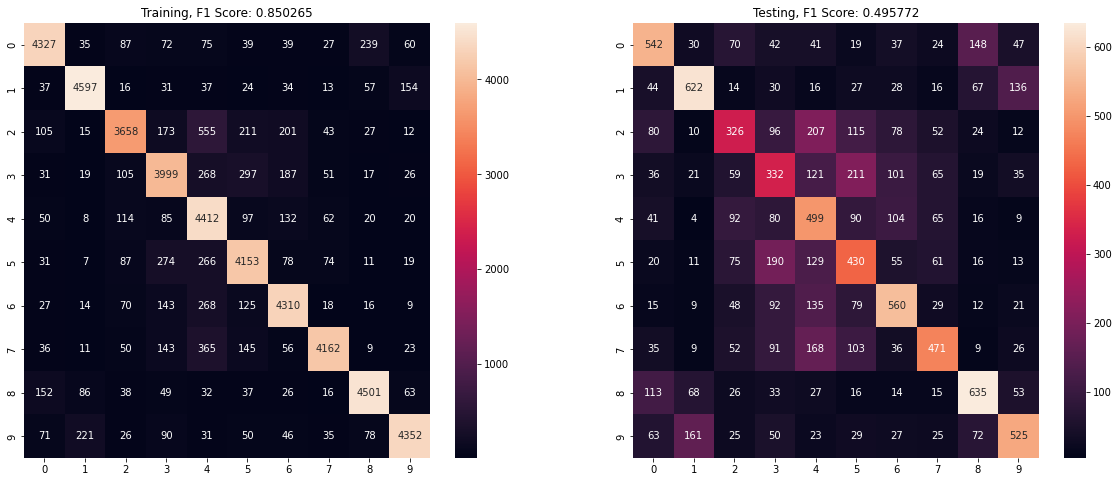

In [6]:
def eval_model(model, train, train_y, test, test_y):
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    # predict on the training set
    pred = model.predict(train, verbose=False);
    # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
    # to a single index
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    # plot the confusion matrix, I'm using tensorflow and seaborn here, but you could use
    # sklearn as well
    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    # set the title to the F1 scope
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    # repeat visualisation for the test set
    ax = fig.add_subplot(1, 2, 2)  
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))
    
eval_model(model_alexnet, train, train_y, test, test_y)

The above confirms what we've seen in the previous plots, we've overfit. We see a large difference in performance between the training and test sets.